# Visualizing Output Data -- WaveMoL
---

Cactus output files can be confusing to a new user. The aim of this tutorial is to provide you with hands-on practice working with output files and visualizing their data. To do this, we will run a simple simulation and then visualize its output.

**Simulation:** we will use the WaveMol example as our test case. The source code is located in `Cactus/arrangements/CactusExamples/WaveMoL`. We will not be writing any source code, creating new thorns, re-compiling Cactus, or anything like that. We will simply modify the WaveMoL parfile (below) so that the simulation generates examples of many of the kinds of output files that you will encounter. If you have a working installation of the Einstein Toolkit, and if you have the necessary Python libraries installed, everything in this notebook should "just work".

**Visualization:** we will use Python's matplotlib graphics library to visualize our simulation data. This is not necessarily the best choice, but it is convenient, especially for a Jupyter notebook-based tutorial such as this. At the very least, visualization in Python can be a useful preliminary diagnostic, before moving to a more advanced tool such as VisIt.

**Python Libraries:** parts of this notebook require NumPy, Matplotlib, and H5Py. Verify that these are installed on your machine before proceding.

**Further Reading:** there is a lot of excellent I/O documentation for Cactus. For example, see the documentation for the 
[IOUtil](http://einsteintoolkit.org/thornguide/CactusBase/IOUtil/documentation.html), 
[IOBasic](http://einsteintoolkit.org/thornguide/CactusBase/IOBasic/documentation.html), 
[IOASCII](http://einsteintoolkit.org/thornguide/CactusBase/IOASCII/documentation.html), 
and 
[IOHDF5](http://einsteintoolkit.org/thornguide/CactusPUGHIO/IOHDF5/documentation.html)
thorns. A condensed very of that material is presented here.

[NOTE: WaveMoL uses a uniform grid and the corresponding PUGH driver. It is very likely that the applications you are interested in will require the Carpet driver instead of PUGH, which allows for mesh refinement. The output files generated by Carpet are slightly more complicated. Unfortunately this tutorial will not examine those output files; maybe there will be a tutorial that will address this in the near future?]

## 0. Preliminaries

First, specify the paths on your machine to the Cactus directory, simulations directory, and the directory where you want to store the edited copy of the WaveMoL parfile.

In [5]:
## Linux example:
cactus_dir = '/home/ejwest/ETK/Cactus'
sims_dir   = '/home/ejwest/ETK/simulations'
par_dir    = '/home/ejwest/ETK/parfiles'

## Windows example:
#cactus_dir = 'C:\\Users\\EJWest\\ETK\\Cactus'
#sims_dir   = 'C:\\Users\\EJWest\\ETK\\Simulations'
#par_dir    = 'C:\\Users\\EJWest\\ETK\\Parfiles'

## Fill in paths to directories:
#cactus_dir = '' #<-- Path to Cactus directory
#sims_dir   = '' #<-- Path to simulations directory
#par_dir    = '' #<-- Path to parfile directory

## 1. Edit Parfile

Next, we create a modified copy of the parfile in the directory that you specified above. The parts of the file that have to do with controlling output have commented headers. For the sake of illustation, here we are generating all three kinds of output files: xgraph-style ASCII, gnuplot-style ASCII, and HDF5.

In [6]:
%%writefile {par_dir}/wave_mol.par
Cactus::cctk_itlast = 100

ActiveThorns = "CoordBase CartGrid3D SymBase Boundary"
ActiveThorns = "PUGHReduce PUGH PUGHSlab"
Grid::domain = "full"
Grid::type = "byspacing"
Grid::avoid_origin = "no"
driver::global_nx = 51
driver::global_ny = 51
driver::global_nz = 51
Grid::dxyz = 0.02
driver::ghost_size = 1

ActiveThorns = "NaNChecker"
ActiveThorns = "LocalReduce"

ActiveThorns = "MoL"
MethodOfLines::ode_method = "icn" #default: icn
        
ActiveThorns = "IDWaveMoL"
IDWaveMoL::initial_data = "gaussian"
IDWaveMoL::amplitude = 1.0 #default: 1.0
IDWaveMoL::radius = 0.0 #default: 0
IDWaveMoL::sigma = 0.1 #default: 0.1
IDWaveMoL::centrex = 0.0 #default: 0
IDWaveMoL::centrey = 0.0 #default: 0
IDWaveMoL::centrez = 0.0 #default: 0
IDWaveMoL::kx = 0.0 #default: 0
IDWaveMoL::ky = 0.0 #default: 0
IDWaveMoL::kz = 0.0 #default: 0
IDWaveMoL::offsett = 0.0 #default: 0
IDWaveMoL::offsetx = 0.0 #default: 0
IDWaveMoL::offsety = 0.0 #default: 0
IDWaveMoL::offsetz = 0.0 #default: 0
IDWaveMoL::slopet = 0.0 #default: 0
IDWaveMoL::slopex = 0.0 #default: 0
IDWaveMoL::slopey = 0.0 #default: 0
IDWaveMoL::slopez = 0.0 #default: 0

ActiveThorns = "WaveMoL"
WaveMoL::bound = "radiation"

ActiveThorns = "Time"
Time::timestep_method = "courant_static"
Time::dtfac = 0.5 #default: 0.5

##--------------------------------------------------------##
## IOUtil                                                 ##
##--------------------------------------------------------##
ActiveThorns = "IOUtil"
IO::out_mode = "proc"
IO::out_dir = $parfile

##--------------------------------------------------------##
## IOBasic - provides I/O methods for outputting scalar   ##
## values in ASCII format into files and for printing     ## 
## them as runtime information to screen                  ##
##--------------------------------------------------------##
ActiveThorns = "IOBasic"

## stdout
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars  = "
        WaveMoL::phi 
        #WaveMoL::energy
"
IOBasic::outInfo_reductions = "minimum maximum"

## ASCII output for scalars
IOBasic::outScalar_every = 1
IOBasic::outScalar_vars  = "
        WaveMoL::phi
        #WaveMoL::energy
"
IOBasic::outScalar_style = "xgraph" #default
#IOBasic::outScalar_style = "gnuplot"

##--------------------------------------------------------##
## IOASCII - provides I/O methods for 1D, 2D, and 3D      ## 
## output of grid arrays and grid functions into files in ##
## ASCII format. The precise format is designed for       ##
## visualisation using the clients xgraph or gnuplot.     ##
##--------------------------------------------------------##
ActiveThorns = "IOASCII"

## ASCII output for 1D slices
IOASCII::out1D_every = 2
IOASCII::out1D_x     = yes
IOASCII::out1D_y     = yes
IOASCII::out1D_z     = yes
IOASCII::out1D_d     = yes       
IOASCII::out1D_vars  = "
        WaveMoL::phi
        #WaveMoL::energy
"
#IOASCII::out1D_style = "xgraph" #default
#IOASCII::out1D_style = "gnuplot f(x)"
IOASCII::out1D_style = "gnuplot f(t,x)"

## ASCII output for 2D slices
IOASCII::out2D_every = 2
IOASCII::out2D_xyplane_z = 0.0
IOASCII::out2D_yzplane_x = 0.0
IOASCII::out2D_xzplane_y = 0.0
IOASCII::out2D_vars  = "
        WaveMoL::phi
        #WaveMoL::energy
"
#IOASCII::out2D_style = "gnuplot f(x,y)" #default
IOASCII::out2D_style = "gnuplot f(t,x,y)"

##--------------------------------------------------------##
## IOHDF5 - provides an I/O method to output variables in ##
## HDF5 file format. It also implements checkpointing and ##
## recovery functionality using HDF5.                     ##
##--------------------------------------------------------##
ActiveThorns = "IOHDF5"
IOHDF5::out_every            = 5
IOHDF5::out_vars             = "
        WaveMoL::phi
        #WaveMoL::energy
        Grid::Coordinates{out_every=1000000000} #we only want this to print once
"
IOHDF5::checkpoint                  = no

Overwriting /home/ejwest/ETK/parfiles/wave_mol.par


## 2. Run Simulation

In [7]:
%rm -rf {sims_dir}/wave_mol

In [8]:
%cd {cactus_dir}
!./simfactory/bin/sim create-run wave_mol --parfile={par_dir}/wave_mol.par --procs=2

/home/ejwest/ETK/Cactus
Parameter file: /home/ejwest/ETK/parfiles/wave_mol.par
Skeleton Created
Job directory: "/home/ejwest/ETK/simulations/wave_mol"
Executable: "/home/ejwest/ETK/Cactus/exe/cactus_sim"
Option list: "/home/ejwest/ETK/simulations/wave_mol/SIMFACTORY/cfg/OptionList"
Submit script: "/home/ejwest/ETK/simulations/wave_mol/SIMFACTORY/run/SubmitScript"
Run script: "/home/ejwest/ETK/simulations/wave_mol/SIMFACTORY/run/RunScript"
Parameter file: "/home/ejwest/ETK/simulations/wave_mol/SIMFACTORY/par/wave_mol.par"
Simulation name: wave_mol
Assigned restart id: 0 
Running simulation wave_mol
Preparing:
+ set -e
+ cd /home/ejwest/ETK/simulations/wave_mol/output-0000-active
+ echo Checking:
Checking:
+ pwd
/home/ejwest/ETK/simulations/wave_mol/output-0000-active
+ hostname
newton
+ date
Tue Jun 25 20:52:59 CDT 2019
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=1
+ export CACTUS_NUM_THREADS=2
+ export GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=2
+ env
+ sort
+ ec

INFO (IOBasic): Periodic scalar output requested for 'WAVEMOL::phi'
INFO (IOBasic): Periodic info output requested for 'WAVEMOL::phi'
-------------------------------------------------
   it  |          | WAVEMOL::phi                |
       |    t     | minimum      | maximum      |
-------------------------------------------------
     0 |    0.000 |-3.332752e-11 |   1.00000000 |
     1 |    0.010 |-2.449807e-21 |   0.97117632 |
     2 |    0.020 |-2.626456e-11 |   0.88848624 |
     3 |    0.030 |-1.124029e-10 |   0.75905317 |
     4 |    0.040 |-1.943181e-10 |   0.59370187 |
     5 |    0.050 |-1.136465e-19 |   0.40576706 |
     6 |    0.060 |-4.549616e-19 |   0.24973675 |
     7 |    0.070 |-1.025856e-18 |   0.19004721 |
     8 |    0.080 |  -0.15235032 |   0.16269231 |
     9 |    0.090 |  -0.29621939 |   0.14744585 |
    10 |    0.100 |  -0.40578000 |   0.13698263 |
    11 |    0.110 |  -0.47829980 |   0.12896727 |
    12 |    0.120 |  -0.51444711 |   0.12223889 |
    13 |    0.13

## 3. Analyze Output

Now move to the output directory for the WaveMoL simulation that we just ran. (This assumes you entered the correct path at the beginning of the notebook.)

In [9]:
%cd {sims_dir}/wave_mol/output-0000/wave_mol

/home/ejwest/ETK/simulations/wave_mol/output-0000/wave_mol


Take a look at the contents of this directory.

In [10]:
%ls

 phi.h5                phi_norm2.xg         'phi_yz_[25].asc'      y.h5
 phi_3D_diagonal.asc  'phi_x_[25][25].asc'  'phi_z_[25][25].asc'   z.h5
 phi_maximum.xg       'phi_xy_[25].asc'      r.h5
 phi_minimum.xg       'phi_xz_[25].asc'      wave_mol.par
 phi_norm1.xg         'phi_y_[25][25].asc'   x.h5


There are three output file format options in Cactus: xgraph-style ASCII (file extension .xg), gnuplot-style ASCII (file extension .asc), or HDF5 (file extension .h5). Notice that all three types of files are present in this example, by design. 

In the parfile above, we selected "scalars" to be written in xgraph-style ASCII format (see the `IOBasic::outScalar` lines). Scalars are quantities that have one value per time step. There are four scalar output files here:

- `phi_maximum.xg` (maximum value of phi over the entire grid, at each time step)
- `phi_minimum.xg` (minimum value of phi over the entire grid, at each time step)
- `phi_norm1.xg` (L1 norm of phi over the entire grid, at each time step)
- `phi_norm2.xg` (L2 norm of phi over the entire grid, at each time step)

In the parfile we selected 1D ASCII output to be written in gnuplot-style format (see the `IOASCII::out1D` lines). 1D output is usually the value of some function along a 1D slice of the computational domain. There are four instances of 1D ASCI output files here:

- `phi_3D_diagonal.asc` (phi along a 3D diagonal of the grid, at each time step)
- `phi_x_[25][25].asc` (phi along the x-axis of the grid, at each time step)
- `phi_y_[25][25].asc` (phi along the y-axis of the grid, at each time step))
- `phi_z_[25][25].asc` (phi along the z-axis of the grid, at each time step)

In the parfile we selected 2D ASCII output to be written in gnuplot-style format (see the `IOASCII::out2D` lines). 2D output is usually the value of some function along a 2D slice of the computational domain. There are three instances of 2D ASCI output files here:

- `phi_xy_[25].asc` (phi along the xy-plane of the grid, at each time step)
- `phi_xz_[25].asc` (phi along the xz-plane of the grid, at each time step)
- `phi_yz_[25].asc` (phi along the yz-plane of the grid, at each time step)

Finally, we selected HDF5 output to also be written (see the `IOHDF5` lines). There are five instances of HDF5 output files here:

- `phi.h5` (phi over the full 3D grid, at each time step)
- `r.h5` (???, at each time step)
- `x.h5` (x coordinates, in 3D meshgrid form, at each time step)
- `y.h5` (y coordinates, in 3D meshgrid form, at each time step)
- `z.h5` (z coordinates, in 3D meshgrid form, at each time step)

We will examine each of these types of output files in turn, starting with the simplest case of scalar output and finishing with the most difficult case of HDF5 output.

## 4. Plotting Scalar Output Data -- ASCII

Scalar output is the simplest to understand, and so this serves as a warm-up case. Scalars usually refer to some global property over the grid at each time step. These are refered to as "reductions" in the Cactus documentation. An example is the average value of a grid function, over the grid, at a given time step. Other examples are the various norms (L1, L2, etc) of a grid function, over the grid, at a given time step.

Scalar output is very simple. It contains two columns: time step and the scalar value at that time step. This is true regardless of whether the output is xgraph-style ASCII (.xg) or gnuplot-style ASCII (.asc). 

Unless you make changes, the parfile above is setup to print xgraph-style ASCII files for scalars. You can repeat the following by modifying the parfile above, re-running the simulation, and then toggle the commented lines below to switch from xgraph to gnuplot style output (i.e., comment out the lines that immediately follow "## xgraph" and uncomment lines that immediately follow "## gnuplot").

Let's list the xgraph-style ASCII files that we have to choose from.

In [206]:
## xgraph
%ls *.xg

## gnuplot
#%ls *.asc

phi_maximum.xg  phi_minimum.xg  phi_norm1.xg  phi_norm2.xg


Choose one of these files to work with. Here we will choose the `phi_norm2` file. To see the structure of the contents of the file, we print the first 10 lines.

In [10]:
### choose a file ###

## xgraph
file1 = 'phi_norm2.xg'

## gnuplot
#file1 = 'phi_norm2.asc'

## print first 10 lines of file
!head -n 10 {file1}

"Parameter file /home/ejwest/ETK/simulations/wave_mol/output-0000/wave_mol.par
"Created Jun 25 2019 14:58:43-0500
"x-label time
"y-label WAVEMOL::phi
"phi v time
0.0000000000000	0.0430714656302
0.0100000000000	0.0424412135368
0.0200000000000	0.0406299532861
0.0300000000000	0.0378277504041
0.0400000000000	0.0343433436474


Notice that xgraph-style files use quotation marks (") to begin comments. Here we see the structure as advertised above. After a few lines of comments, the file contains two columns, with the structure

- Column 1: time step
- Column 2: scalar data

Next we assign those data to a numpy array.

In [11]:
## import numpy library
import numpy as np

## xgraph
data1 = np.loadtxt(file1, comments='"')

## gnuplot
#data1 = np.loadtxt(file1, comments='#')

## print data to screen (optional)
print(data1)

[[0.00000000e+00 4.30714656e-02]
 [1.00000000e-02 4.24412135e-02]
 [2.00000000e-02 4.06299533e-02]
 [3.00000000e-02 3.78277504e-02]
 [4.00000000e-02 3.43433436e-02]
 [5.00000000e-02 3.05957402e-02]
 [6.00000000e-02 2.70964847e-02]
 [7.00000000e-02 2.43927425e-02]
 [8.00000000e-02 2.29176547e-02]
 [9.00000000e-02 2.27728350e-02]
 [1.00000000e-01 2.36622366e-02]
 [1.10000000e-01 2.50991811e-02]
 [1.20000000e-01 2.66542269e-02]
 [1.30000000e-01 2.80537122e-02]
 [1.40000000e-01 2.91679775e-02]
 [1.50000000e-01 2.99679978e-02]
 [1.60000000e-01 3.04842889e-02]
 [1.70000000e-01 3.07754688e-02]
 [1.80000000e-01 3.09065163e-02]
 [1.90000000e-01 3.09355441e-02]
 [2.00000000e-01 3.09076003e-02]
 [2.10000000e-01 3.08536523e-02]
 [2.20000000e-01 3.07926823e-02]
 [2.30000000e-01 3.07350033e-02]
 [2.40000000e-01 3.06854421e-02]
 [2.50000000e-01 3.06457280e-02]
 [2.60000000e-01 3.06159775e-02]
 [2.70000000e-01 3.05954820e-02]
 [2.80000000e-01 3.05830802e-02]
 [2.90000000e-01 3.05773390e-02]
 [3.000000

Then for the sake of code-readability, we can assign meaningful names to different parts of the data.

In [12]:
## get time steps
time_steps = data1[:,0]  #every row, first col

## get scalar values
phi_norm2  = data1[:,1]  #every row, second col

## print data to screen (optional)
print('time_steps = ', time_steps)
print('phi_norm2 = ', phi_norm2)

time_steps =  [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
phi_norm2 =  [0.04307147 0.04244121 0.04062995 0.03782775 0.03434334 0.03059574
 0.02709648 0.02439274 0.02291765 0.02277284 0.02366224 0.02509918
 0.02665423 0.02805371 0.02916798 0.029968   0.03048429 0.03077547
 0.03090652 0.03093554 0.0309076  0.03085365 0.03079268 0.030735
 0.03068544 0.03064573 0.03061598 0.03059548 0.03058308 0.03057734
 0.03057667 0.0305794  0.03058388 0.03058847 0.03059154 0.03059143
 0.03058634 0.03057423 0.03055276 0.03051918 0.03047037 0.0

And finally we can plot the scalar data versus time.

<IPython.core.display.Javascript object>


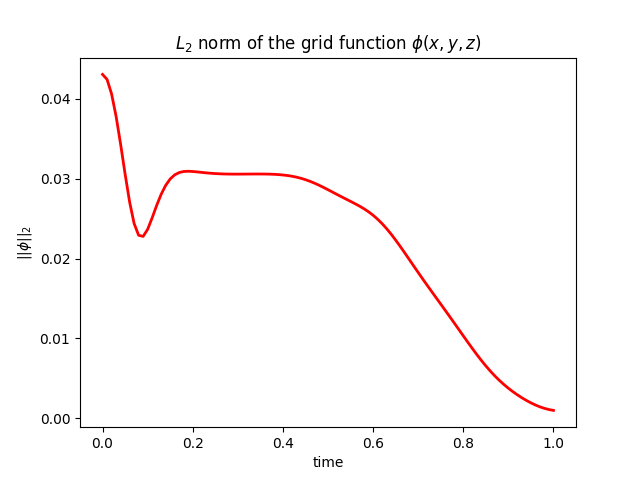

In [13]:
## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt

## plot
plt.plot(time_steps, phi_norm2, color='red', linewidth=2)
plt.title(r'$L_{2}$ norm of the grid function $\phi(x,y,z)$')
plt.xlabel('time')
plt.ylabel(r'$||\phi||_{2}$')
plt.show()

### Exercises

1) Plot the maximum value of phi as a function of time.

2) Modify the parfile above to print gnuplot-style ASCII output for scalars. Then plot the L2 norm of phi as a function of time.

3) Modify the parfile above to print scalar output for energy. Then plot the L2 norm for energy as a function of time.

## 5. Plotting 1D Output Data -- ASCII

1D output data is slightly more complicated than the scalar case. Here we begin to see structural differences between xgraph-style and gnuplot-style ASCII files. 

A 1D slice returns the value of some grid function along a ray in the computational domain. An example would be some evolved variable along the x-axis at each time step.

The form of the output depends on the style that you specify in the parfile:

- `IOASCII::out1D_style = "xgraph"`$\rightarrow$ two columns: x, f(x)
- `IOASCII::out1D_style = "gnuplot f(x)"` $\rightarrow$ two columns: x, f(x)
- `IOASCII::out1D_style = "gnuplot f(t,x)"` $\rightarrow$ three columns: t, x, f(t,x)

Unless you make changes, the parfile above is setup to print gnuplot-style ASCII files for 1D slices using the "f(t,x)" format.

Let's list the gnuplot-style ASCII files that we have to choose from.

In [14]:
## xgraph
#%ls *.xg

## gnuplot
%ls *.asc

 phi_3D_diagonal.asc  'phi_xz_[25].asc'     'phi_z_[25][25].asc'
'phi_x_[25][25].asc'  'phi_y_[25][25].asc'
'phi_xy_[25].asc'     'phi_yz_[25].asc'


Choose one of these files to work with. Here we will choose the `phi_x` file. To see the structure of the contents of the file, we print the first 10 lines.

In [15]:
### choose a file ###

## xgraph
#file2 = 'phi_x_[25][25].xg'

## gnuplot
file2 = 'phi_x_[25][25].asc'

## print first 10 lines of file
!head -n 10 {file2}

#Parameter file /home/ejwest/ETK/simulations/wave_mol/output-0000/wave_mol.par
#Created Jun 25 2019 14:58:43-0500
#x-label x
#y-label WAVEMOL::phi (y = 0.0000000000000, z = 0.0000000000000), (yi = 25, zi = 25)

#Time = 0.0000000000000
0.0000000000000		-0.5000000000000		-0.0000000000333
0.0000000000000		-0.4800000000000		0.0000000000986
0.0000000000000		-0.4600000000000		0.0000000006461
0.0000000000000		-0.4400000000000		0.0000000039089


Notice that gnuplot-style files use the hash symbol (#) to begin comments. After a few lines of comments, the file contains three columns, with the structure

- Column 1: time step 
- Column 2: grid values (slice coordinate)
- Column 3: grid function values

Time steps are printed in the first column because "gnuplot f(t,x)" was selected in the parfile. The other options would have been to use "gnuplot f(x)" or "xgraph", in which case only two columns would appear (which appear here as columns 2 and 3).

Next we assign the data to a numpy array.

In [16]:
## import numpy library
import numpy as np

## xgraph
#data2 = np.loadtxt(file2, comments='"')

## gnuplot
data2 = np.loadtxt(file2, comments='#')

## print data to screen (optional)
print(data2)

[[ 0.00000000e+00 -5.00000000e-01 -3.33000000e-11]
 [ 0.00000000e+00 -4.80000000e-01  9.86000000e-11]
 [ 0.00000000e+00 -4.60000000e-01  6.46100000e-10]
 ...
 [ 1.00000000e+00  4.60000000e-01  1.13449791e-04]
 [ 1.00000000e+00  4.80000000e-01  4.96059158e-05]
 [ 1.00000000e+00  5.00000000e-01  1.57013113e-05]]


Next we would like to assign meaningful names to different parts of the data. However, this time things are slightly more complicated by the block structure of the data, which schematically looks something like this

\begin{align}
\text{block 1}\left\{
  \begin{array}{ccc}
  \tt{t1} & \tt{x1} & \tt{f(t1, x1)} \\
  \tt{t1} & \tt{x2} & \tt{f(t1, x2)} \\
  \tt{t1} & \tt{x3} & \tt{f(t1, x3)} \\
  \end{array}\right.
\end{align}

\begin{align}
\text{block 2}\left\{
  \begin{array}{ccc}
  \tt{t2} & \tt{x1} & \tt{f(t2, x1)} \\
  \tt{t2} & \tt{x2} & \tt{f(t2, x2)} \\
  \tt{t2} & \tt{x3} & \tt{f(t2, x3)} \\
  \end{array}\right.
\end{align}

\begin{align}
\text{block 3}\left\{
  \begin{array}{ccc}
  \tt{t3} & \tt{x1} & \tt{f(t3, x1)} \\
  \tt{t3} & \tt{x2} & \tt{f(t3, x2)} \\
  \tt{t3} & \tt{x3} & \tt{f(t3, x3)} \\
  \end{array}\right.
\end{align}

One way to handle this is as follows.

1. Create a 1D array of time steps by scanning the entire first column and keeping the unique elements.
2. Create a 1D array of spatial grid values by scanning the entire second column and keeping the unique elements.
3. Create a 2D array of grid function values: each row corresponding to a different time step.

In [18]:
### gnuplot, f(t,x) ###

## identify columns
t_col = 0
x_col = 1
f_col = 2

## step 1: get unique time steps
time_steps = np.unique(data2[:,t_col])
tdim = len(time_steps)

## step 2: get unique spatial grid values
xvals = np.unique(data2[:,x_col])
xdim = len(xvals)

## step 3: get data
phi_x = np.zeros((tdim, xdim))
for i in range(tdim):
    ## get time step
    tstep = time_steps[i]
    ## fetch corresponding data
    tsdata = data2[data2[:,t_col]==tstep, :] 
    ## save data to arrays
    phi_x[i,:] = tsdata[:, f_col]

## print data to screen (optional)
print('time_steps = ', time_steps)
print('xvals =', xvals)
print('phi_x = ', phi_x)

time_steps =  [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
xvals = [-0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3  -0.28
 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06 -0.04
 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2
  0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44
  0.46  0.48  0.5 ]
phi_x =  [[-3.33000000e-11  9.86000000e-11  6.46100000e-10 ...  6.46100000e-10
   9.86000000e-11 -3.33000000e-11]
 [-2.63000000e-11  5.98400000e-10  3.21100000e-09 ...  3.21100000e-09
   5.98400000e-10 -2.63000000e-11]
 [-1.94300000e-10  6.46070000e-09  2.84807000e-08 ...  2.84807000e-08
   6.46070000e-09 -1.94300000e-10]
 ...
 [ 3.81652987e-04  1.44415718e-04 -1.00162780e-04 ... -1.00162780e-04
   1.444

The following cell contains the analogous commands if you use "gnuplot f(x)" style output instead. (Try it!)

In [ ]:
### gnuplot, f(x) ###

## identify columns
#x_col = 0
#f_col = 1

## step 1: get unique time steps
#import re
#fh = open(file2).read()
#time_steps = []
#for line in re.findall('#Time =.*', fh):
#    tstep = float(line.split()[2])
#    time_steps.append(tstep)
#f.close()
#time_steps = np.array(time_steps)
#time_steps
#tdim = len(time_steps)

## step 2: get unique spatial grid values
#xvals = np.unique(data2[:,x_col])
#xdim = len(xvals)

## step 3: get data
#phi_x = np.zeros((tdim, xdim))
#for i in range(tdim):
#    ## get grid value
#    xstep = xvals[i]
#    ## fetch corresponding data
#    xsdata = data2[data2[:,x_col]==xstep, :] 
#    ## save data to arrays
#    phi_x[:,i] = xsdata[:, f_col]

## print data to screen (optional)
#print('time_steps = ', time_steps)
#print('xvals =', xvals)
#print('phi_x = ', phi_x)

Now we are ready to plot the data in whatever way we like.

### Plot snapshot

<IPython.core.display.Javascript object>


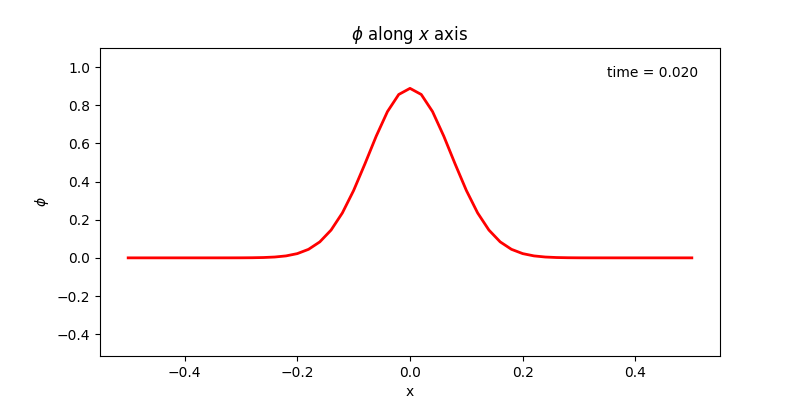

In [99]:
## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt

## figure properties
fig_width = 8
fig_height = 4
minval = np.min(phi_x)
maxval = np.max(phi_x)

## choose a time step
tstep = 1

## plot
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_subplot(111)
ax.plot(xvals[:], phi_x[tstep,:], color='red', linewidth=2)
ax.set_ylim(minval, 1.1*maxval)
ax.set_title(r'$\phi$ along $x$ axis')
ax.set_xlabel('x')
ax.set_ylabel(r'$\phi$')
ax.text(0.35, 0.95, 'time = %.3f' % time_steps[tstep])
plt.show()

### Plot animation

In [98]:
## import graphics libraries
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## figure properties
fig_width = 8
fig_height = 4
minval = np.min(phi_x)
maxval = np.max(phi_x)

### initialize plot
plt.ioff()
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_subplot(111)
ax.set_ylim(minval, 1.1*maxval)
time = time_steps[tstep]
ax.text(0.35, 0.95, 'time = %.3f' % time)
scene = ax.plot(xvals[:], phi_x[0,:], color='red', linewidth=2)

## update plot
def update_scene(frame_number, xvals, phi_x, scene):
    ax.cla()
    ax.set_ylim(minval, 1.1*maxval)
    time = time_steps[frame_number]
    ax.text(0.35, 0.95, 'time = %.3f' % time)
    scene = ax.plot(xvals[:], phi_x[frame_number,:], color='red', linewidth=2)

## make animation
fps=5
frames=np.arange(0, len(time_steps), 1)
anim = animation.FuncAnimation(
    fig, update_scene, frames, fargs=(xvals, phi_x, scene), 
    interval=1000/fps, blit=False, repeat=False)
plt.close()

## play animation
from IPython.display import HTML
HTML(anim.to_html5_video())  #playback option 1
#HTML(anim.to_jshtml())       #playback option 2

### Exercises

1) Plot phi_z as a function of time.

2) Modify the parfile to use the "gnuplot f(x)" style for 1D output and then replot phi_x as a function of time.

3) Modify the parfile to use the "xgraph" style for 1D output and then replot phi_x as a function of time.

## 6. Plotting 2D Output Data -- ASCII

The output for 2D slices is more complicated still. In this case there is no xgraph-style ASCII option. But as with 1D slices, there are two gnuplot-style options.

A 2D slice returns the value of some grid function along a plane in the computational domain. An example would be some evolved variable over the xy-plane at each time step.

The form of the output depends on the style that you specify in the parfile:

- `IOASCII::out2D_style = "gnuplot f(x,y)"` $\rightarrow$ three columns: x, y, f(x,y)
- `IOASCII::out2D_style = "gnuplot f(t,x,y)"` $\rightarrow$ four columns: t, x, y, f(t,x,y)

Unless you make changes, the parfile above is setup to print gnuplot-style ASCII files for 2D slices using the "f(t,x,y)" format.

Re-list the gnuplot-style ASCII files that we have to choose from.

In [83]:
%ls *.asc

 phi_3D_diagonal.asc  'phi_xz_[25].asc'     'phi_z_[25][25].asc'
'phi_x_[25][25].asc'  'phi_y_[25][25].asc'
'phi_xy_[25].asc'     'phi_yz_[25].asc'


Choose a file to work with. Here we will take the `phi_xy` file, which gives the grid function phi on the xy-plane, at each time step.

In [84]:
### choose a file ###
file3 = 'phi_xy_[25].asc'

## print first 10 lines
!head -n 10 {file3}

#Parameter file /home/ejwest/ETK/simulations/wave_mol/output-0000/wave_mol.par
#Created Jun 25 2019 14:58:43-0500
#x-label x
#y-label y
#z-label WAVEMOL::phi (z = 0.0000000000000), (zi = 25)

#Time = 0.0000000000000
0.0000000000000		-0.5000000000000		-0.5000000000000		0.0000000000000
0.0000000000000		-0.5000000000000		-0.4800000000000		-0.0000000000000
0.0000000000000		-0.5000000000000		-0.4600000000000		-0.0000000000000


After a few lines of comments, the file contains four columns, with the structure

- Column 1: time step 
- Column 2: grid values (first slice coordinate)
- Column 3: grid values (second slice coordinate)
- Column 4: grid function values

Time steps are printed in the first column because "gnuplot f(t,x,y)" was selected in the parfile. The other option would have been to use "gnuplot f(x,y)", in which case only three columns would appear (which appear here as columns 2-4).

Next we assign the data to a numpy array.

In [85]:
## import numpy library
import numpy as np

## get data
data3 = np.loadtxt(file3, comments='#')

## print data to screen (optional)
print(data3)

[[ 0.00000000e+00 -5.00000000e-01 -5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-01 -4.80000000e-01 -0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-01 -4.60000000e-01 -0.00000000e+00]
 ...
 [ 1.00000000e+00  5.00000000e-01  4.60000000e-01 -1.00437602e-03]
 [ 1.00000000e+00  5.00000000e-01  4.80000000e-01 -9.92674028e-04]
 [ 1.00000000e+00  5.00000000e-01  5.00000000e-01 -7.10693002e-04]]


Next we would like to assign meaningful names to different parts of the data. This time the structure schematically looks something like this

\begin{align}
\text{block 1}\left\{
  \begin{array}{cccc}
  \tt{t1} & \tt{x1} & \tt{y1} & \tt{f(t1, x1, y1)} \\
  \tt{t1} & \tt{x1} & \tt{y2} & \tt{f(t1, x1, y2)} \\
  \tt{t1} & \tt{x1} & \tt{y3} & \tt{f(t1, x1, y3)} \\
  \end{array}\right.
\end{align}

\begin{align}
\text{block 2}\left\{
  \begin{array}{cccc}
  \tt{t1} & \tt{x2} & \tt{y1} & \tt{f(t1, x2, y1)} \\
  \tt{t1} & \tt{x2} & \tt{y2} & \tt{f(t1, x2, y2)} \\
  \tt{t1} & \tt{x2} & \tt{y3} & \tt{f(t1, x2, y3)} \\
  \end{array}\right.
\end{align}

\begin{align}
\text{block 3}\left\{
  \begin{array}{cccc}
  \tt{t1} & \tt{x3} & \tt{y1} & \tt{f(t1, x3, y1)} \\
  \tt{t1} & \tt{x3} & \tt{y2} & \tt{f(t1, x3, y2)} \\
  \tt{t1} & \tt{x3} & \tt{y3} & \tt{f(t1, x3, y3)} \\
  \end{array}\right.
\end{align}

\begin{align}
\text{block 4}\left\{
  \begin{array}{cccc}
  \tt{t2} & \tt{x1} & \tt{y1} & \tt{f(t2, x1, y1)} \\
  \tt{t2} & \tt{x1} & \tt{y2} & \tt{f(t2, x1, y2)} \\
  \tt{t2} & \tt{x1} & \tt{y3} & \tt{f(t2, x1, y3)} \\
  \end{array}\right.
\end{align}

\begin{align}
\text{block 5}\left\{
  \begin{array}{cccc}
  \tt{t2} & \tt{x2} & \tt{y1} & \tt{f(t2, x2, y1)} \\
  \tt{t2} & \tt{x2} & \tt{y2} & \tt{f(t2, x2, y2)} \\
  \tt{t2} & \tt{x2} & \tt{y3} & \tt{f(t2, x2, y3)} \\
  \end{array}\right.
\end{align}

\begin{align}
\text{block 6}\left\{
  \begin{array}{cccc}
  \tt{t2} & \tt{x3} & \tt{y1} & \tt{f(t2, x3, y1)} \\
  \tt{t2} & \tt{x3} & \tt{y2} & \tt{f(t2, x3, y2)} \\
  \tt{t2} & \tt{x3} & \tt{y3} & \tt{f(t2, x3, y3)} \\
  \end{array}\right.
\end{align}

We can handle this is as follows.

1. Create a 1D array of time steps by scanning the entire first column and keeping the unique elements.
2. Create a 1D array of spatial grid values by scanning the entire second column and keeping the unique elements.
3. Create a 1D array of spatial grid values by scanning the entire third column and keeping the unique elements.
4. Create a 3D array of grid function values: each row corresponding to a different time step.

In [86]:
### gnuplot, f(t,x,y) ###

## identify columns
t_col = 0
x_col = 1
y_col = 2
f_col = 3

## step 1: get unique time steps
time_steps = np.unique(data3[:,t_col])
tdim = len(time_steps)

## step 2: get unique spatial grid values
xvals = np.unique(data3[:,x_col])
xdim = len(xvals)

## step 3: get unique spatial grid values
yvals = np.unique(data3[:,y_col])
ydim = len(yvals)

## step 4: get data
phi_xy = np.zeros((tdim, xdim, ydim))
for n in range(tdim):
    ## get time step
    tstep = time_steps[n]
    ## fetch corresponding data
    tsdata = data3[data3[:,t_col]==tstep, :]
    for i in range(xdim):
        ## get grid value
        xval = xvals[i]
        ## fetch corresponding data
        xsdata = tsdata[tsdata[:,x_col]==xval, :]
        ## save data to arrays
        phi_xy[n,i,:] = xsdata[:, f_col]

## print data to screen (optional)
print('time_steps = ', time_steps)
print('xvals =', xvals)
print('yvals =', yvals)
#print('phi_xy = ', phi_xy)

time_steps =  [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
xvals = [-0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3  -0.28
 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06 -0.04
 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2
  0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44
  0.46  0.48  0.5 ]
yvals = [-0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3  -0.28
 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06 -0.04
 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2
  0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44
  0.46  0.48  0.5 ]


Now that the data is extracted into numpy arrays, we can visualize in various ways. Here we will illustrate a couple of examples: we will make a color map using imshow() and a surface plot using plot_surface(). In addition, as above, we may either create a snapshot of the solution or an animation.

### Color map snapshot

<IPython.core.display.Javascript object>


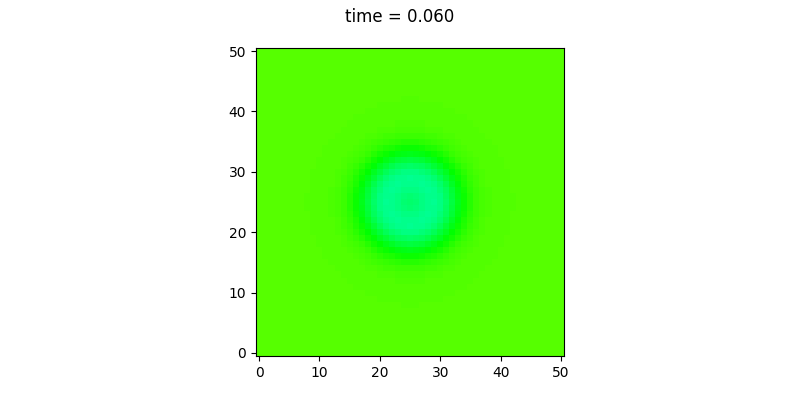

In [120]:
### plot snapshot using imshow() ###

## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(phi_xy)
maxval = np.max(phi_xy)

## choose a time step
tstep = 3

## plot
time = time_steps[tstep]
fig = plt.figure(figsize=(fig_width, fig_height))
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111)
zi = phi_xy[tstep,:,:]
ax.imshow(zi, cmap=cmap, clim=(minval, maxval), origin='lower')
plt.show()

### Color map animation

In [122]:
### animate using imshow() ###

## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(phi_xy)
maxval = np.max(phi_xy)

## initialize plot
plt.ioff()
time = time_steps[tstep]
fig = plt.figure(figsize=(fig_width, fig_height))
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111)
zi = phi_xy[0,:,:]
scene = [ax.imshow(zi, cmap=cmap, clim=(minval, maxval), origin='lower')]

## update plot
def update_plot(frame_number, time_steps, phi_xy, scene):
    time = time_steps[frame_number]
    fig.suptitle('time = %.3f' % time)
    zi = phi_xy[frame_number,:,:]
    scene[0] = ax.imshow(zi, cmap=cmap, clim=(minval, maxval), origin='lower')

## make animation
fps=5
frames=np.arange(0, len(time_steps), 1)
anim = animation.FuncAnimation(
    fig, update_plot, frames, fargs=(time_steps, phi_xy, scene), 
    interval=1000/fps, blit=False, repeat=False)
plt.close()

## play animation
from IPython.display import HTML
HTML(anim.to_html5_video())  #playback option 1
#HTML(anim.to_jshtml())       #playback option 2

### Surface plot snapshot

<IPython.core.display.Javascript object>


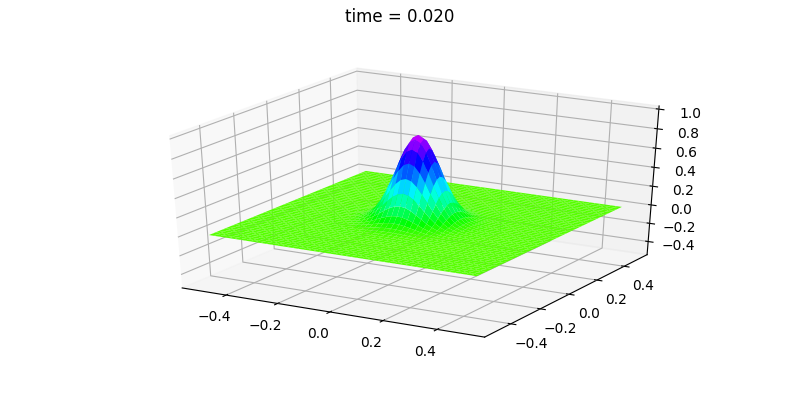

In [123]:
### plot snapshot using plot_surface() ###

## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(phi_xy)
maxval = np.max(phi_xy)

## choose a time step
tstep = 1

## plot
fig = plt.figure(figsize=(fig_width, fig_height))
time = time_steps[tstep]
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(minval, maxval)
xi, yi = np.meshgrid(xvals, yvals)
zi = phi_xy[tstep,:,:]
ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))
plt.show()

### Surface plot animation

In [127]:
### animate using plot_surface() ###

## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.animation as animation

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(phi_xy)
maxval = np.max(phi_xy)

## initialize plot
plt.ioff()
fig = plt.figure(figsize=(fig_width, fig_height))
time = time_steps[0]
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(minval, maxval)
xi, yi = np.meshgrid(xvals, yvals)
zi = phi_xy[0,:,:]
scene = [ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))]

## update plot
def update_plot(frame_number, time_steps, phi_xy, scene):
    time = time_steps[frame_number]
    fig.suptitle('time = %.3f' % time)
    scene[0].remove()
    zi = phi_xy[frame_number,:,:]
    scene[0] = ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))

## make animation
fps=5
frames=np.arange(0, len(time_steps), 1)
anim = animation.FuncAnimation(
    fig, update_plot, frames, fargs=(time_steps, phi_xy, scene), 
    interval=1000/fps, blit=False, repeat=False)
plt.close()

## play animation
from IPython.display import HTML
HTML(anim.to_html5_video())  #playback option 1
#HTML(anim.to_jshtml())       #playback option 2

In [126]:
## save animation to file
anim_file = 'wave_mol'
#anim.save(anim_file + '.mp4', writer='ffmpeg', fps=fps) # requires ffmpeg
anim.save(anim_file + '.gif', writer='imagemagick', fps=fps)

### Exercises

1) Plot phi_yz as a function of time.

2) Modify the parfile to use the "gnuplot f(x,y)" style for 2D output and then replot phi_xy as a function of time.

3) Plot energy as a function of space and time.

## 7. Extracting Data from HDF5 Files 

HDF5 (Hierarchical Data Format 5) is a portable binary data format. As such, it is far more efficient to read and write than ASCII formats, and it is probably what you should normally use for visualizing large simulations. A nice tool for visualizing simulation data in HDF5 format is VisIt. However, the H5Py library provides methods for interfacing with HDF5 files using Python. This is the approach we will take here. Once the data are extracted from the .h5 files, they can be visualized as normal using matplotlib.

In order to extract information from an HDF5 file, it helps to have at least some familiarity with how they are structured. This section will take a brief detour into exploring the basics of HDF5 so that the remainder of the tutorial doesn't seem like "black magic". If you just want to get to visualization and are ok with a little black magic, you can skip to the next section.

Before doing anything else, let's import the H5Py library.

In [113]:
## import h5py library
import h5py

Now list the available HDF5 files.

In [114]:
%ls *.h5

phi.h5  r.h5  x.h5  y.h5  z.h5


Then choose a file to work with. Here we will examine the `phi.h5` file.

In [115]:
## create file handle
file4 = h5py.File('phi.h5', mode='r')

HDF5 files are not plain text files, so you can't read them using a text editor (try!). The basic elements of an HDF5 file are "groups" and "datasets". You can think of groups like directories or folders, and you can think of datasets like files. In addition, both groups and datasets have "attributes" that contain metadata about that object. Let's start by exploring the primary groups in our file. 

In [116]:
## get (name, value) tuples for members of the root group
## (the root group, called '/', is the top-level group in the file)
list(file4.items())

[('Cactus Parameters', <HDF5 group "/Cactus Parameters" (1 members)>),
 ('Global Attributes', <HDF5 group "/Global Attributes" (0 members)>),
 ('WAVEMOL::phi timelevel 0 at iteration 0',
  <HDF5 dataset "WAVEMOL::phi timelevel 0 at iteration 0": shape (51, 51, 51), type "<f8">),
 ('WAVEMOL::phi timelevel 0 at iteration 10',
  <HDF5 dataset "WAVEMOL::phi timelevel 0 at iteration 10": shape (51, 51, 51), type "<f8">),
 ('WAVEMOL::phi timelevel 0 at iteration 100',
  <HDF5 dataset "WAVEMOL::phi timelevel 0 at iteration 100": shape (51, 51, 51), type "<f8">),
 ('WAVEMOL::phi timelevel 0 at iteration 15',
  <HDF5 dataset "WAVEMOL::phi timelevel 0 at iteration 15": shape (51, 51, 51), type "<f8">),
 ('WAVEMOL::phi timelevel 0 at iteration 20',
  <HDF5 dataset "WAVEMOL::phi timelevel 0 at iteration 20": shape (51, 51, 51), type "<f8">),
 ('WAVEMOL::phi timelevel 0 at iteration 25',
  <HDF5 dataset "WAVEMOL::phi timelevel 0 at iteration 25": shape (51, 51, 51), type "<f8">),
 ('WAVEMOL::phi ti

Here we see that the root group contains two subgroups, `Cactus Parameters` and `Global Attributes`, in addition to several datasets with names of the form `WAVEMOL::phi timelevel 0 at iteration NN`. In the parfile above, we asked for HDF5 output every 5 time steps (see the `IOHDF5::out_every` line). Correspondingly, here we see that there is a dataset for every fifth time step (iteration). 

In general an HDF5 file could have a complicated group hierarchy with subgroups nested within subgroups, nested within subgroups, etc. Of the two groups in our file, one is empty (`Global Attributes` is listed as having zero "members", i.e., nothing in it) and one is not (`Cactus Parameters` is listed as having one member, which may be a dataset or another group). The following cell gives us a quick way to preview the entire hierarchy.

In [117]:
## traverse the group hierarchy
file4.visit(lambda x: print(x))

Cactus Parameters
Cactus Parameters/All Parameters
Global Attributes
WAVEMOL::phi timelevel 0 at iteration 0
WAVEMOL::phi timelevel 0 at iteration 10
WAVEMOL::phi timelevel 0 at iteration 100
WAVEMOL::phi timelevel 0 at iteration 15
WAVEMOL::phi timelevel 0 at iteration 20
WAVEMOL::phi timelevel 0 at iteration 25
WAVEMOL::phi timelevel 0 at iteration 30
WAVEMOL::phi timelevel 0 at iteration 35
WAVEMOL::phi timelevel 0 at iteration 40
WAVEMOL::phi timelevel 0 at iteration 45
WAVEMOL::phi timelevel 0 at iteration 5
WAVEMOL::phi timelevel 0 at iteration 50
WAVEMOL::phi timelevel 0 at iteration 55
WAVEMOL::phi timelevel 0 at iteration 60
WAVEMOL::phi timelevel 0 at iteration 65
WAVEMOL::phi timelevel 0 at iteration 70
WAVEMOL::phi timelevel 0 at iteration 75
WAVEMOL::phi timelevel 0 at iteration 80
WAVEMOL::phi timelevel 0 at iteration 85
WAVEMOL::phi timelevel 0 at iteration 90
WAVEMOL::phi timelevel 0 at iteration 95


From the above, we learn that the hierarchy in this case is not very deep or complicated. It should be clear that our data are in the `WAVEMOL::phi` datasets; there are no further datasets burried elsewhere in the hierarchy. The next cell extracts the first of these datasets in order to examine it further.

In [118]:
## dictionary-like lookup (works for datasets as well as groups)
dset1 = file4['/WAVEMOL::phi timelevel 0 at iteration 0']
print(dset1)

<HDF5 dataset "WAVEMOL::phi timelevel 0 at iteration 0": shape (51, 51, 51), type "<f8">


The next cell prints some of the main attributes of the dataset.

In [119]:
## get dataset attributes
print('dataset name is', dset1.name)
print('dataset type is', dset1.dtype)
print('dataset shape is', dset1.shape)

dataset name is /WAVEMOL::phi timelevel 0 at iteration 0
dataset type is float64
dataset shape is (51, 51, 51)


The next cell lists any additional attributes (metadata) that are stored with the dataset.

In [110]:
## retreive (name, value) tuples of dataset attributes 
list(dset1.attrs.items())

[('delta', array([0.02, 0.02, 0.02])),
 ('global_size', array([51, 51, 51], dtype=int32)),
 ('groupname', b'WAVEMOL::SCALAREVOLVEMOL_SCALAR'),
 ('grouptype', 402),
 ('max_ext', array([0.5, 0.5, 0.5])),
 ('min_ext', array([-0.5, -0.5, -0.5])),
 ('ntimelevels', 3),
 ('origin', array([-0.5, -0.5, -0.5])),
 ('time', 0.0)]

Finally, the next cell illustrates how to retreive data in a dataset and store it in a NumPy array.

In [111]:
## extract data from dataset using the '[...]' syntax
npdset1 = dset1[...]
print(npdset1)

[[[-2.83522667e-34  4.71893648e-33  3.71268542e-32 ...  3.71268542e-32
    4.71893648e-33 -2.83522667e-34]
  [ 4.71893648e-33 -7.06414674e-32 -5.05684173e-31 ... -5.05684173e-31
   -7.06414674e-32  4.71893648e-33]
  [ 3.71268542e-32 -5.05684173e-31 -3.60180626e-30 ... -3.60180626e-30
   -5.05684173e-31  3.71268542e-32]
  ...
  [ 3.71268542e-32 -5.05684173e-31 -3.60180626e-30 ... -3.60180626e-30
   -5.05684173e-31  3.71268542e-32]
  [ 4.71893648e-33 -7.06414674e-32 -5.05684173e-31 ... -5.05684173e-31
   -7.06414674e-32  4.71893648e-33]
  [-2.83522667e-34  4.71893648e-33  3.71268542e-32 ...  3.71268542e-32
    4.71893648e-33 -2.83522667e-34]]

 [[ 4.71893648e-33 -7.06414674e-32 -5.05684173e-31 ... -5.05684173e-31
   -7.06414674e-32  4.71893648e-33]
  [-7.06414674e-32  9.58441060e-31  6.28114815e-30 ...  6.28114815e-30
    9.58441060e-31 -7.06414674e-32]
  [-5.05684173e-31  6.28114815e-30  4.11635349e-29 ...  4.11635349e-29
    6.28114815e-30 -5.05684173e-31]
  ...
  [-5.05684173e-31  6.2

The following cell verifies that this resulting object is indeed a NumPy array.

In [112]:
type(npdset1)

numpy.ndarray

At this point, we treat the data object as we would treat any other NumPy array. In the next section, we use what we have learned in this section to extract our data and then visualize them.

## 8. Plotting 2D Output Data -- HDF5

Now we return to the task of visualizing the data in an HDF5 (.h5) file. First import H5Py and NumPy.

In [148]:
## import libraries
import numpy as np
import h5py

List the available HDF5 files.

In [149]:
%ls *.h5

phi.h5  r.h5  x.h5  y.h5  z.h5


Choose a file to work with. Here we will examine the `phi.h5` file.

In [150]:
## create file handle
phi_h5 = h5py.File('phi.h5', mode='r')

The following cell extracts the time steps from the metadata of the HDF5 file.

In [151]:
## get time steps
time_steps = np.array([])
for member in phi_h5:
    ## find members with shape attributes
    ## (only datasets have shape attribute)
    if hasattr(phi_h5[member], 'shape'):
        ## get time of dataset
        ts = phi_h5[member].attrs['time']
        ## append time to time_steps
        time_steps = np.append(time_steps, ts)
    ## sort
    time_steps = np.sort(time_steps)

## print to screen (optional)
print("time_steps = ", time_steps)

time_steps =  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In order to plot using `plot_surface()`, we need to construct an xy-meshgrid. The grid information is not stored in the `phi.h5` file, but instead is found in `x.h5`, `y.h5`, and `z.h5`. The following cell retrieves this information.

In [207]:
## get 3D xdata, ydata, zdata
x_h5 = h5py.File("x.h5")
y_h5 = h5py.File("y.h5")
z_h5 = h5py.File("z.h5")

for member in x_h5:
    if hasattr(x_h5[member], 'shape'):
        xdata = x_h5[member][...]
        break #we only need one copy, since we are dealing with a fixed grid
for member in y_h5:
    if hasattr(y_h5[member], 'shape'):
        ydata = y_h5[member][...]
        break #we only need one copy, since we are dealing with a fixed grid
for member in z_h5:
    if hasattr(z_h5[member], 'shape'):
        zdata = z_h5[member][...]
        break #we only need one copy, since we are dealing with a fixed grid

## print to screen (optional)
print("xdata = ", xdata)
print("ydata = ", ydata)
print("zdata = ", zdata)

xdata =  [[[-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  ...
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]]

 [[-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  ...
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]]

 [[-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  ...
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]]

 ...

 [[-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
  ...
  [-0.5  -0.48 -0.46 ...  0.46 

The next cell extracts the values of phi over the xy-grid at each time step.

In [208]:
## get dimensions of time and space grids
tdim = len(time_steps)
xdim = len(xdata[0,0,:]) # indices: [z,y,x]
ydim = len(ydata[0,:,0]) # indices: [z,y,x]
zdim = len(ydata[:,0,0]) # indices: [z,y,x]

## get 3D phidata
phidata = np.zeros((tdim, xdim, ydim, zdim))
for i in range(tdim):
    ## get time step
    tstep = time_steps[i]
    ## find dataset with matching time step
    for member in phi_h5:
        if hasattr(phi_h5[member], 'shape'):
            if phi_h5[member].attrs['time'] == tstep: 
                ## save dataset as element of numpy array
                phidata[i,:,:,:] = phi_h5[member][...]

## get zstep for xy-plane
for i in range(zdim):
    if zdata[i,0,0]==0:
        z_xyplane = i

## get phi_xy_data
phi_xy = phidata[:, z_xyplane, :, :]

## print to screen (optional)
print('phi_xy =', phi_xy)

phi_xy = [[[ 2.74206881e-22 -1.68264035e-21 -1.16712047e-20 ... -1.16712047e-20
   -1.68264035e-21  2.74206881e-22]
  [-1.68264035e-21  9.72098502e-21  6.37065226e-20 ...  6.37065226e-20
    9.72098502e-21 -1.68264035e-21]
  [-1.16712047e-20  6.37065226e-20  4.17501006e-19 ...  4.17501006e-19
    6.37065226e-20 -1.16712047e-20]
  ...
  [-1.16712047e-20  6.37065226e-20  4.17501006e-19 ...  4.17501006e-19
    6.37065226e-20 -1.16712047e-20]
  [-1.68264035e-21  9.72098502e-21  6.37065226e-20 ...  6.37065226e-20
    9.72098502e-21 -1.68264035e-21]
  [ 2.74206881e-22 -1.68264035e-21 -1.16712047e-20 ... -1.16712047e-20
   -1.68264035e-21  2.74206881e-22]]

 [[-1.13646508e-19  4.38070362e-19  2.27667625e-18 ...  2.27667625e-18
    4.38070362e-19 -1.13646508e-19]
  [ 4.38070362e-19  3.64500332e-17  1.70150974e-16 ...  1.70150974e-16
    3.64500332e-17  4.38070362e-19]
  [ 2.27667625e-18  1.70150974e-16  7.87356964e-16 ...  7.87356964e-16
    1.70150974e-16  2.27667625e-18]
  ...
  [ 2.27667625

The next cell gets 2D meshgrid slices of xdata and ydata.

In [209]:
## get 2D meshgrid data
xvals = xdata[z_xyplane,:,:]
yvals = ydata[z_xyplane,:,:]

## print to screen (optional)
print('xvals =', xvals)
print('yvals =', yvals)

xvals = [[-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
 [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
 [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
 ...
 [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
 [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]
 [-0.5  -0.48 -0.46 ...  0.46  0.48  0.5 ]]
yvals = [[-0.5  -0.5  -0.5  ... -0.5  -0.5  -0.5 ]
 [-0.48 -0.48 -0.48 ... -0.48 -0.48 -0.48]
 [-0.46 -0.46 -0.46 ... -0.46 -0.46 -0.46]
 ...
 [ 0.46  0.46  0.46 ...  0.46  0.46  0.46]
 [ 0.48  0.48  0.48 ...  0.48  0.48  0.48]
 [ 0.5   0.5   0.5  ...  0.5   0.5   0.5 ]]


Now plot exactly as before. (The cells used to make the color map plots are exactly as before, copied and pasted from above. The cells used to make the surface plots are slightly modifed, due to the fact that our `xvals` and `yvals` are already in meshgrid form.)

### Color map snapshot

<IPython.core.display.Javascript object>


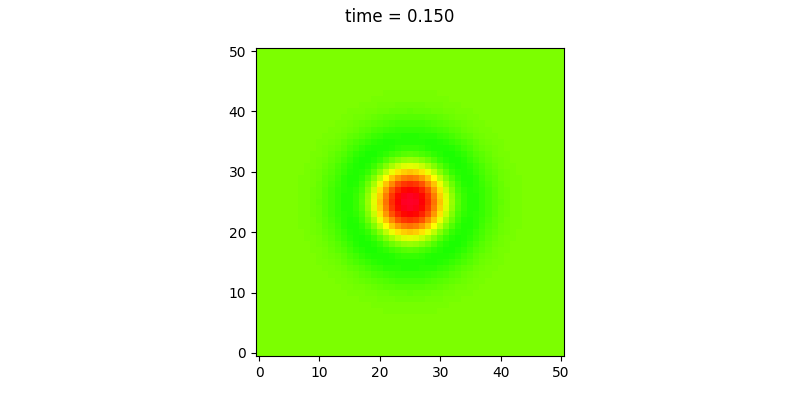

In [210]:
### plot snapshot using imshow() ###

## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(phi_xy)
maxval = np.max(phi_xy)

## choose a time step
tstep = 3

## plot
time = time_steps[tstep]
fig = plt.figure(figsize=(fig_width, fig_height))
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111)
zi = phi_xy[tstep,:,:]
ax.imshow(zi, cmap=cmap, clim=(minval, maxval), origin='lower')
plt.show()

### Color map animation

In [211]:
### animate using imshow() ###

## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(phi_xy)
maxval = np.max(phi_xy)

## initialize plot
plt.ioff()
time = time_steps[tstep]
fig = plt.figure(figsize=(fig_width, fig_height))
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111)
zi = phi_xy[0,:,:]
scene = [ax.imshow(zi, cmap=cmap, clim=(minval, maxval), origin='lower')]

## update plot
def update_plot(frame_number, time_steps, phi_xy, scene):
    time = time_steps[frame_number]
    fig.suptitle('time = %.3f' % time)
    zi = phi_xy[frame_number,:,:]
    scene[0] = ax.imshow(zi, cmap=cmap, clim=(minval, maxval), origin='lower')

## make animation
fps=5
frames=np.arange(0, len(time_steps), 1)
anim = animation.FuncAnimation(
    fig, update_plot, frames, fargs=(time_steps, phi_xy, scene), 
    interval=1000/fps, blit=False, repeat=False)
plt.close()

## play animation
from IPython.display import HTML
HTML(anim.to_html5_video())  #playback option 1
#HTML(anim.to_jshtml())       #playback option 2

### Surface plot snapshot

<IPython.core.display.Javascript object>


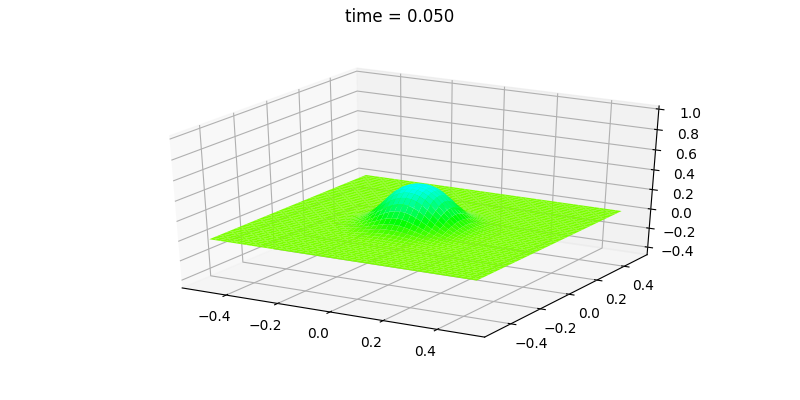

In [204]:
### plot snapshot using plot_surface() ###

## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(phi_xy)
maxval = np.max(phi_xy)

## choose a time step
tstep = 1

## plot
fig = plt.figure(figsize=(fig_width, fig_height))
time = time_steps[tstep]
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(minval, maxval)
## this was the old line which no longer works here
#xi, yi = np.meshgrid(xvals, yvals)
## this is the new way of doing things
xi = xvals #xvals is already in mesh grid form
yi = yvals #yvals is already in mesh grid form
zi = phi_xy[tstep,:,:]
ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))
plt.show()

### Surface plot animation

In [205]:
### animate using plot_surface() ###

## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.animation as animation

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(phi_xy)
maxval = np.max(phi_xy)

## initialize plot
plt.ioff()
fig = plt.figure(figsize=(fig_width, fig_height))
time = time_steps[0]
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(minval, maxval)
## this was the old line which no longer works here
#xi, yi = np.meshgrid(xvals, yvals)
## this is the new way of doing things
xi = xvals #xvals is already in mesh grid form
yi = yvals #yvals is already in mesh grid form
zi = phi_xy[0,:,:]
scene = [ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))]

## update plot
def update_plot(frame_number, time_steps, phi_xy, scene):
    time = time_steps[frame_number]
    fig.suptitle('time = %.3f' % time)
    scene[0].remove()
    zi = phi_xy[frame_number,:,:]
    scene[0] = ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))

## make animation
fps=5
frames=np.arange(0, len(time_steps), 1)
anim = animation.FuncAnimation(
    fig, update_plot, frames, fargs=(time_steps, phi_xy, scene), 
    interval=1000/fps, blit=False, repeat=False)
plt.close()

## play animation
from IPython.display import HTML
HTML(anim.to_html5_video())  #playback option 1
#HTML(anim.to_jshtml())       #playback option 2

In [126]:
## save animation to file
anim_file = 'wave_mol'
#anim.save(anim_file + '.mp4', writer='ffmpeg', fps=fps) # requires ffmpeg
anim.save(anim_file + '.gif', writer='imagemagick', fps=fps)

### Exercises

1) Plot phi_yz as a function of time using the data in `phi.h5`.

2) Plot phi_xz as a function of time using the data in `phi.h5`.

3) Plot phi_xy on the upper/lower z=const boundary.

4) Change the frequency of hdf5 output and replot phi_xy.

5) Plot energy in the xy plane as a function of time.